In [1]:
import ROOT as r 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Welcome to JupyROOT 6.24/02


In [2]:
directory= "/Users/adit/Google Drive/Internship_ Research/Muon g-2/Data Filed/combined_forAdit_timealigned.root"
f = r.TFile(directory)

In [3]:
f.cd('LaserEvents')
t = f.Get('LaserEvents/tree')
df = pd.DataFrame(r.RDataFrame(t).AsNumpy())
c= r.TCanvas()

In [7]:
run = 25026
subRun = 2
fill = 178
calo = 16
xtal =3


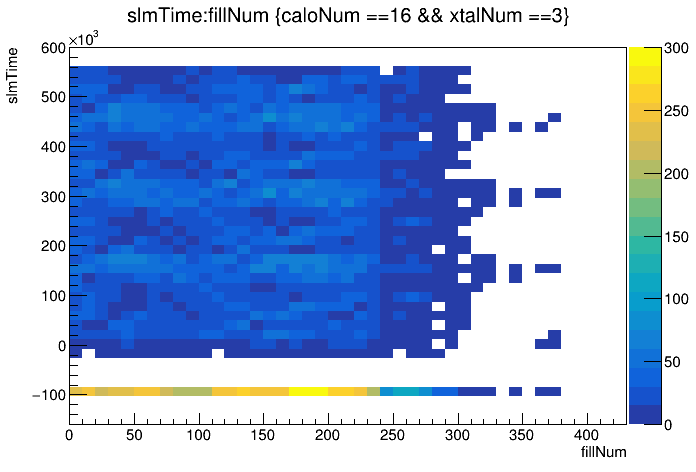

In [8]:
t.Draw('slmTime:fillNum', "caloNum =={} && xtalNum =={}".format(calo,xtal), 'colz')
c.Draw()

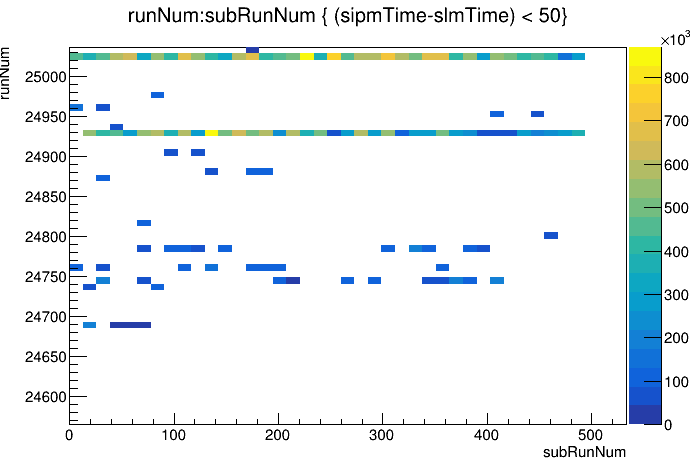

In [9]:
t.Draw('runNum:subRunNum',' (sipmTime-slmTime) < 50','colz')
c.Draw()

Error in <THistPainter::PaintInit>: log scale requested with a negative argument (-1.000000)
Error in <THistPainter::PaintInit>: log scale requested with a negative argument (-1.000000)
Error in <THistPainter::PaintInit>: log scale requested with a negative argument (-1.000000)


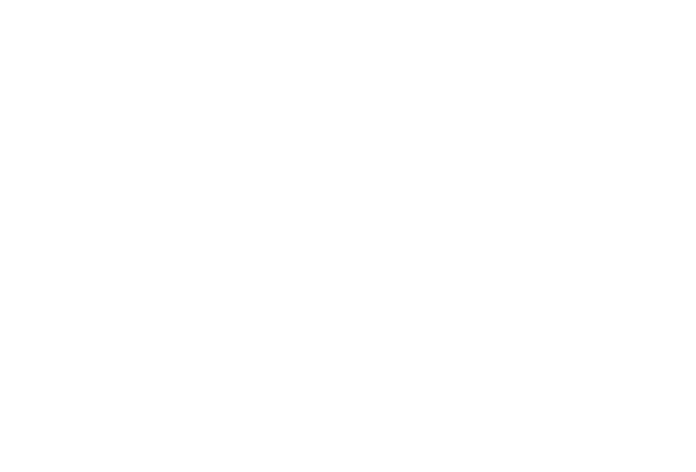

In [199]:
t.Draw('caloNum:xtalNum', "runNum =={} && subRunNum=={} && fillNum == {}".format(run,subRun,fillNum), 'colz')
c.Draw()

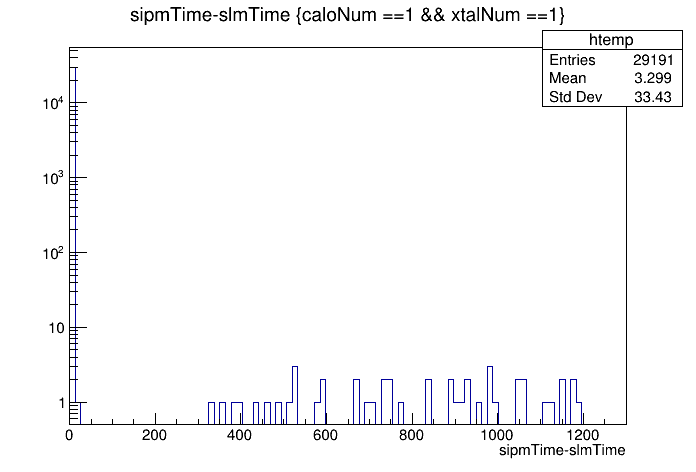

In [10]:
t.Draw('sipmTime-slmTime', "caloNum ==1 && xtalNum ==1")
c.SetLogy()
c.Draw()

In [6]:
print(df.describe())
print(df.nunique())
print(df.head())

       gpsTimeStamp  cccTimeStamp        runNum     subRunNum       fillNum  \
count  3.779552e+07  3.779552e+07  3.779552e+07  3.779552e+07  3.779552e+07   
mean   1.555790e+09  9.911910e+10  2.496101e+04  2.245266e+02  1.342963e+02   
std    2.544310e+05  5.867342e+10  8.201021e+01  1.350690e+02  7.734417e+01   
min    1.554982e+09  2.163583e+08  2.468500e+04  0.000000e+00  1.000000e+00   
25%    1.555664e+09  4.969637e+10  2.492800e+04  1.090000e+02  6.600000e+01   
50%    1.556000e+09  9.647675e+10  2.502600e+04  2.150000e+02  1.370000e+02   
75%    1.556003e+09  1.477690e+11  2.502600e+04  3.380000e+02  1.960000e+02   
max    1.556034e+09  2.220666e+11  2.503200e+04  4.930000e+02  3.770000e+02   

           bunchNum    fillType       caloNum       xtalNum      sipmTime  \
count  3.779552e+07  37795516.0  3.779552e+07  3.779552e+07  3.779552e+07   
mean   7.500986e+00         1.0  1.249642e+01  2.651775e+01  1.989889e+05   
std    4.609085e+00         0.0  6.923995e+00  1.557810e+

In [11]:
df_filtered = df.loc[(df['sipmTime']-df['slmTime']) < 50]

In [12]:
df_noise = df.loc[(df['sipmTime']-df['slmTime']) > 50]
#evaluated this in a diff notebook, nothing significant, no commonalities, only 47 of 29k entries

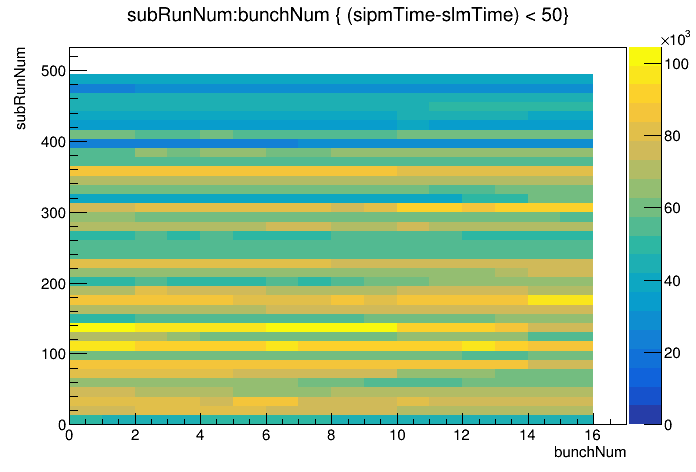

In [42]:
t.Draw('subRunNum:bunchNum',' (sipmTime-slmTime) < 50','colz')
c2.Draw()
#interesitng property, number of data points is consistent across a subRun i.e. no cuts within a bunch

In [ ]:
#fullRunPulse = df_xtal[(df_xtal['runNum']== 24928)]
#avgSyncPulse = fullRunPulse[fullRunPulse['slmTime']<-10000].groupby('fillNum').count()

In [13]:
df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
syncPulse = df_xtal.groupby(['runNum','subRunNum','fillNum']).min()
syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
df_xtal  = pd.merge(df_xtal,syncPulse['syncEnergy'], how = 'inner', on = ['runNum','subRunNum','fillNum'])
df_xtal['normalSlmEnergy'] = (df_xtal['slmEnergy']/df_xtal['syncEnergy'])

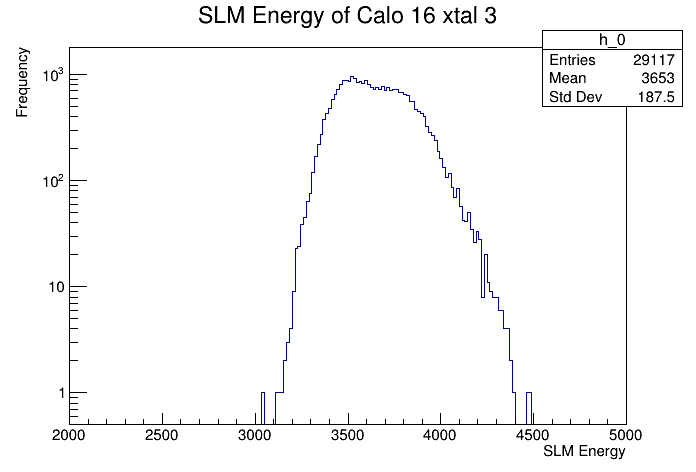

In [14]:
h0 = r.TH1D(f"h_{0}", "SLM Energy of Calo {} xtal {}; SLM Energy; Frequency".format(calo,xtal), 200, 2000, 5000)

for x in df_xtal['slmEnergy']:
    h0.Fill(x)

h0.Draw()
c.Draw()


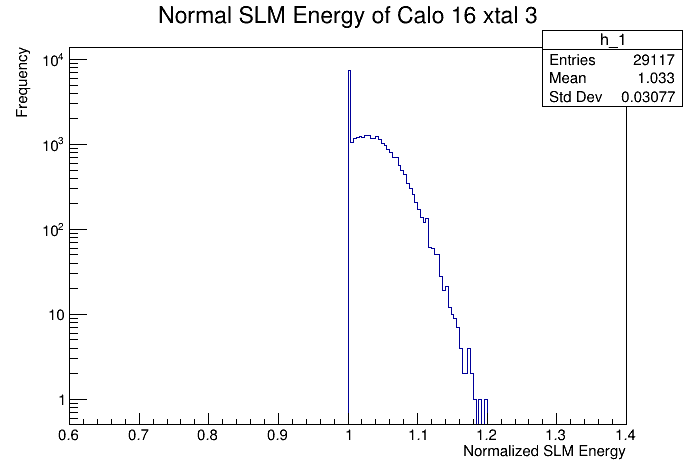

In [15]:
c.SetLogy()

h1 = r.TH1D(f"h_{1}", "Normal SLM Energy of Calo {} xtal {}; Normalized SLM Energy; Frequency".format(calo,xtal), 200, 0.6, 1.4)

for x in df_xtal['normalSlmEnergy']:
    h1.Fill(x)

h1.Draw()
c.Draw()


Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).


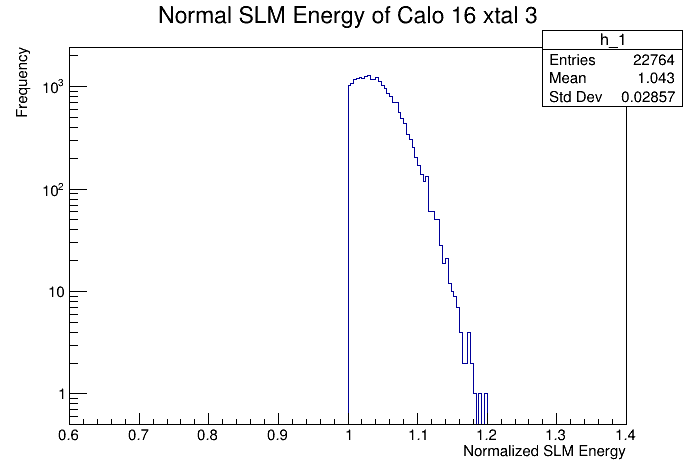

In [16]:
#looking at non sync pulses to see if they are major contributor

h1 = r.TH1D(f"h_{1}", "Normal SLM Energy of Calo {} xtal {}; Normalized SLM Energy; Frequency".format(calo,xtal), 200, 0.6, 1.4)

for x in df_xtal[df_xtal['normalSlmEnergy']!=1]['normalSlmEnergy']:
    h1.Fill(x)

h1.Draw()
c.Draw()

# still the curve in one- sided Gaussian, definitely tells us other -n- fill pulses are more energetic than sync Pulse

Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).


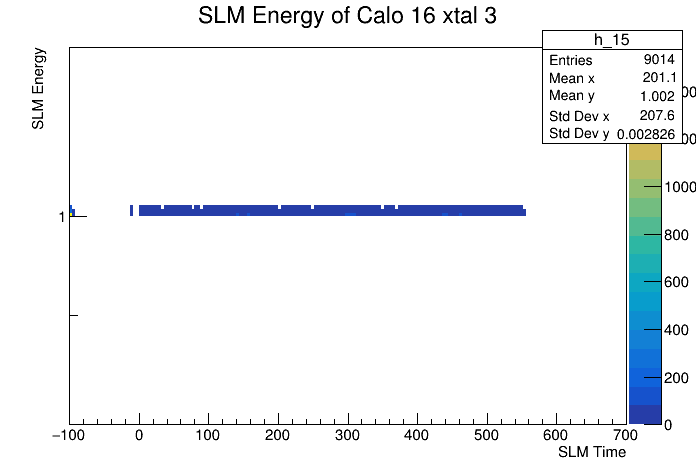

In [17]:
h15 = r.TH2D(f"h_{15}", "SLM Energy of Calo {} xtal {};SLM Time; SLM Energy".format(calo,xtal), 200, -100, 700, 100, 0.8, 1.2)

for (x,y) in zip(df_xtal[df_xtal['normalSlmEnergy']<1.01]['slmTime'],df_xtal[df_xtal['normalSlmEnergy']<1.01]['normalSlmEnergy']):
    h15.Fill(x/1000,y)

h15.Draw('colz')
c.Draw()

h1 = r.TH1D(f"h_{1}", "SLM Energy of Calo {} xtal {}; Normalized SLM Energy; Frequency".format(calo,xtal), 200, 0.6, 1.4)

#examing their time dependence foesn't give any cocrete 

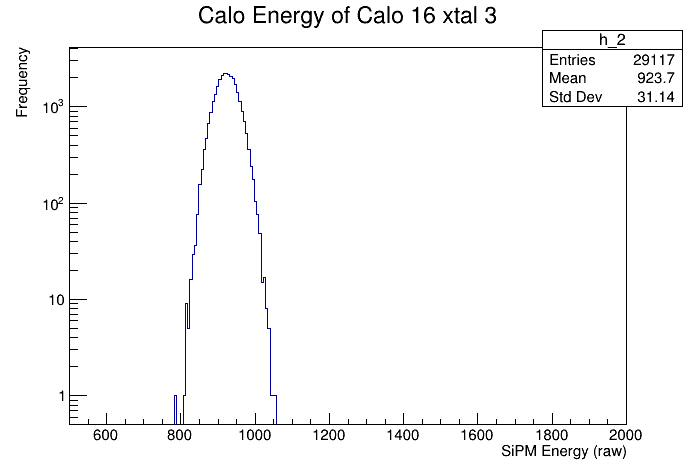

In [18]:
h2 = r.TH1D(f"h_{2}", "Calo Energy of Calo {} xtal {}; SiPM Energy (raw); Frequency".format(calo,xtal), 250, 500, 2000)

for x in df_xtal['sipmEnergy']:
    h2.Fill(x)

h2.Draw()
c.Draw()



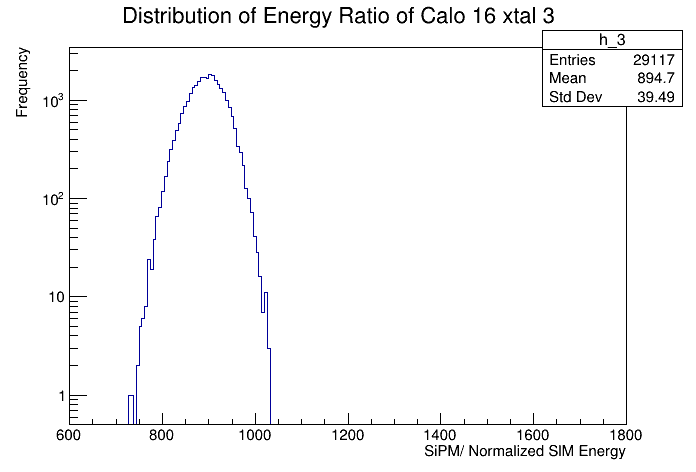

In [19]:
h3 = r.TH1D(f"h_{3}", "Distribution of Energy Ratio of Calo {} xtal {}; SiPM/ Normalized SlM Energy; Frequency".format(calo,xtal), 200, 600, 1800)

for x in df_xtal['sipmEnergy']/df_xtal['normalSlmEnergy']:
    h3.Fill(x)

h3.Draw()
c.Draw()

mean_temp = h3.GetMean()


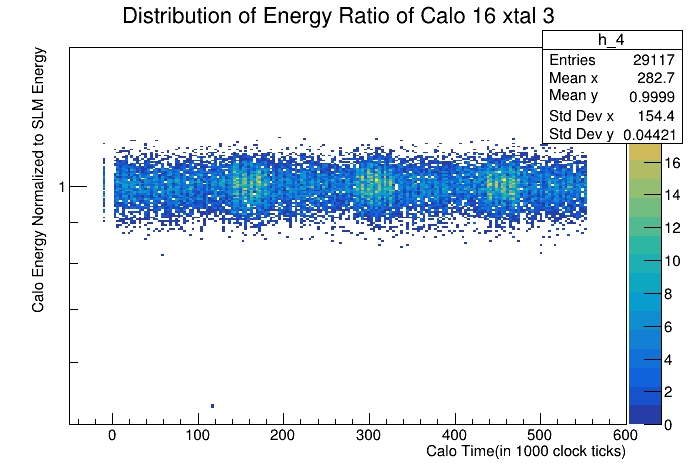

In [20]:
h4 = r.TH2D(f"h_{4}", "Distribution of Energy Ratio of Calo {} xtal {}; Calo Time(in 1000 clock ticks); Calo Energy Normalized to SLM Energy".format(calo,xtal),
            200, -50, 600,
            200,0.5,1.5)

for (x,y) in zip(df_xtal['sipmTime'], df_xtal['sipmEnergy']/df_xtal['normalSlmEnergy']/mean_temp):
    h4.Fill(x/1000,y)

h4.Draw('colz')
c.Draw()



Slope: -5.230016271103264e-10
Standard Deviation: 0.00035838797562049194


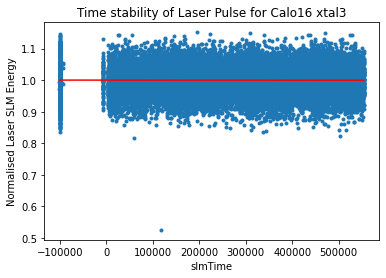

In [21]:
fig,ax = plt.subplots()
ax.plot(df_xtal['sipmTime'], df_xtal['sipmEnergy']/df_xtal['normalSlmEnergy']/mean_temp,".")
ax.set_title("Time stability of Laser Pulse for Calo{} xtal{}".format(calo,xtal))
ax.set_xlabel("slmTime")
ax.set_ylabel("Normalised Laser SLM Energy")
# fit a curve (linear for now) through the stability of time 


def func(x,m,b):
    return m*x + b 

initial_guess = [1.2, 0.03]
pars, pcov = curve_fit(func, df_xtal['sipmTime'], df_xtal['sipmEnergy']/df_xtal['normalSlmEnergy']/mean_temp, p0=initial_guess)
xfit = np.linspace(np.amin(df_xtal['sipmTime']),np.amax(df_xtal['sipmTime']))
yfit = func(xfit, pars[0], pars[1])
plt.plot(xfit,yfit,'r-',label=f"Linear Fit\nm={pars[0]:.2f}\nb={pars[1]:.2f}")

print("Slope: {}".format(pars[0]))
print("Standard Deviation: {}".format(np.sqrt(pcov.trace())))

In [22]:
timeGrowth = np.zeros((24,54))
timeStd = np.zeros((24,54))

for calo in pd.unique(df['caloNum']):
    for xtal in  pd.unique(df['xtalNum']):

        df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
        syncPulse = df_xtal.groupby(['runNum','subRunNum','fillNum']).min()
        syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
        df_xtal  = pd.merge(df_xtal,syncPulse['syncEnergy'], how = 'inner', on = ['runNum','subRunNum','fillNum'])
        df_xtal['normalSlmEnergy'] = (df_xtal['slmEnergy']/df_xtal['syncEnergy'])
        
        mean = df_xtal['sipmEnergy']/df_xtal['normalSlmEnergy'].mean()
        
        def func(x,m,b):
            return m*x + b 

        initial_guess = [1.2, 0.03]
        pars, pcov = curve_fit(func, df_xtal['sipmTime'], df_xtal['sipmEnergy']/df_xtal['normalSlmEnergy']/mean, p0=initial_guess)

        timeGrowth[calo-1][xtal] = pars[0]
        timeStd[calo-1][xtal] = np.sqrt(pcov[1,1])

ValueError: `ydata` must not be empty!

In [ ]:
plt.rcParams["figure.figsize"] = (12,6) 

for calo in pd.unique(df['caloNum']):
    plt.matshow(timeGrowth[calo-1].reshape(6,9), cmap=plt.cm.Blues)
    plt.title('Calo {}'.format(calo))
    plt.colorbar()
    

In [ ]:
plt.rcParams["figure.figsize"] = (18,9) 

for calo in pd.unique(df['caloNum']):
    plt.matshow(timeStd[calo-1].reshape(6,9), cmap=plt.cm.Blues)
    plt.title('Calo {}'.format(calo))
    plt.colorbar()

    